In [1]:
import os
# import open3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib import colors
plt.rcParams["font.family"] = "serif" # Font controller
plt.rcParams["font.serif"] = ["Arial"]
plt.rcParams["font.size"] = 11 # Default=10
import pickle
import vis_utilities as vis_util
import eval_utilities as eval_util

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Load all the val frames
val_file = '/pcc-storage/KITTI/ImageSets/val.txt'
with open(val_file, 'r') as f:
    lines = f.readlines()
val_inds = [int(line) for line in lines]

bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

In [3]:
# Generate distance statistics: Only need to run once
# Histogram of all the object distances
path_gt_bbox_val = '/home/user/PCcompression/Results/bbox_data/gt_bbox_val.pickle'
path_gt_bbox_origin_val = '/home/user/PCcompression/Results/bbox_data/gt_bbox_origin_val.pickle'
if not os.path.exists(path_gt_bbox_val) or not os.path.exists(path_gt_bbox_origin_val):
    velo_pos_val_set = [] # the bbox points list, each element inside this list is a ndarray containing the object bbox positions 3 x 8 x #objects
    velo_origin_val_set = [] # the origin points list, each element inside this list is a ndarray containing the object origins 
    for _, frame_ind in enumerate(val_inds):
        print(frame_ind)
        frame_ind_str = format(frame_ind, '06')
        #Load ground truth 3d bounding boxes
        velo_pos_all, origin_all, N_obj_care = vis_util.load_gt_3d_bbox(frame_ind_str)
        velo_pos_val_set.append(velo_pos_all)
        velo_origin_val_set.append(origin_all)
    with open(path_gt_bbox_val, 'wb') as handle:
        pickle.dump(velo_pos_val_set, handle, protocol=-1)
    with open(path_gt_bbox_origin_val, 'wb') as handle:
        pickle.dump(velo_origin_val_set, handle, protocol=-1)

In [4]:

print(len(val_inds))
with open(path_gt_bbox_val, 'rb') as handle:
    velo_pos_val_set = pickle.load(handle)
with open(path_gt_bbox_origin_val, 'rb') as handle:
    velo_origin_val_set = pickle.load(handle)

figure_dir='/home/user/PCcompression/Results/figures/AP_vs_distance/'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

3769


In [5]:
def find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set):
    IoU_type = 0
    # Load ignored_gt list
    ignored_gts_file = '/home/user/PCcompression/Results/pcdet_object_analysis_second/raw/ignored_gts_class'\
        +str(obj_class)+'_diff'+str(difficulty)+'_type'+str(IoU_type)+'.npy' 
    ignored_gts_list = np.load(ignored_gts_file,allow_pickle=True)
    # Collect a list of valid gt bounding boxes
    valid_gt_bboxes = []
    valid_gt_origins = []
    valid_gt_bboxes_per_frame = []
    valid_gt_origins_per_frame = []
    dist_per_frame = []
    for val_frame_order, velo_pos_val in enumerate(velo_pos_val_set):
        valid_bboxes_cur_frame = []
        valid_origins_cur_frame = []
        dist_cur_frame = []
        val_frame_ind = val_inds[val_frame_order]
        velo_origin_val = velo_origin_val_set[val_frame_order]
        for i in range(0, velo_pos_val.shape[2]):
            if (ignored_gts_list[val_frame_order][i]==0):
                valid_gt_bboxes.append(velo_pos_val[:,:,i])
                valid_gt_origins.append(velo_origin_val[:, i])
                valid_bboxes_cur_frame.append(velo_pos_val[:,:,i])
                valid_origins_cur_frame.append(velo_origin_val[:, i])
        valid_gt_bboxes_per_frame.append(valid_bboxes_cur_frame)
        valid_gt_origins_per_frame.append(valid_origins_cur_frame)
        dist_cur_frame = [np.sqrt(origin[0]**2 + origin[1]**2) for ind, origin in enumerate(valid_origins_cur_frame)]
        dist_per_frame.append(dist_cur_frame)
    dist = [np.sqrt(origin[0]**2 + origin[1]**2) for ind, origin in enumerate(valid_gt_origins)]
    return valid_gt_bboxes, valid_gt_origins, dist, valid_gt_bboxes_per_frame, valid_gt_origins_per_frame, dist_per_frame


{'Car': [2906, 7874, 10960], 'Pedestrian': [1134, 1739, 2172], 'Cyclist': [281, 544, 600]}


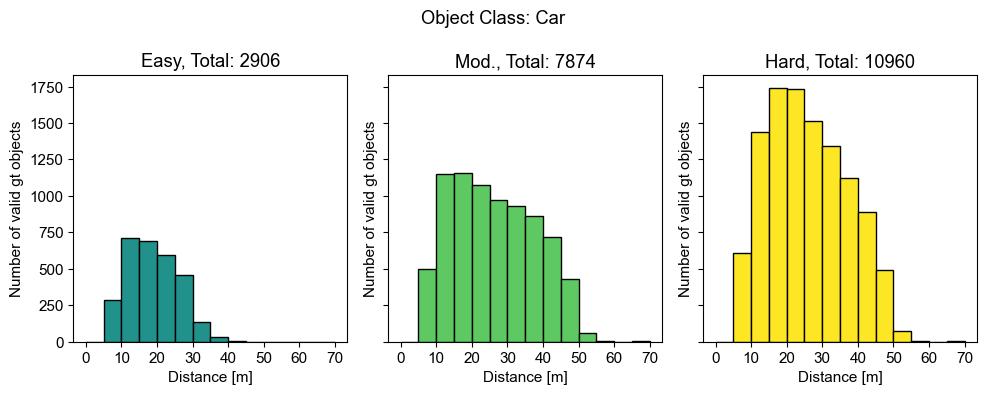

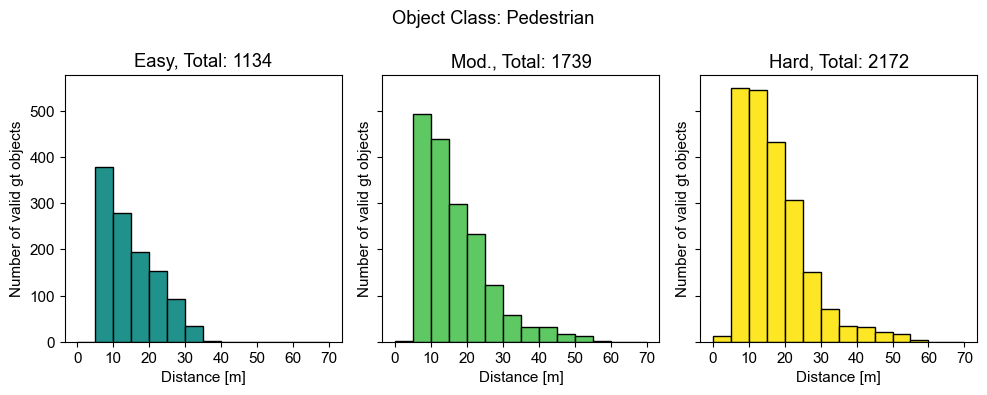

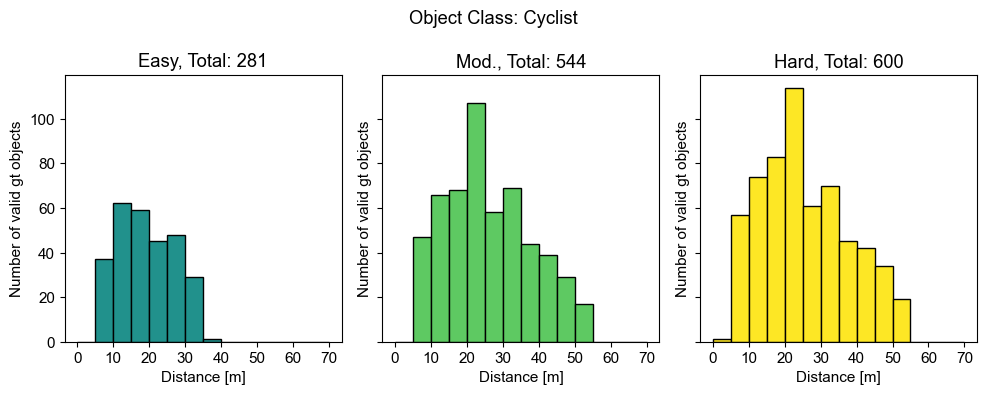

In [6]:
# Load non-detected list
class_list=['Car','Pedestrian','Cyclist']
difficulty_list=['Easy','Mod.','Hard']
valid_gt_count = {'Car':[0, 0, 0], 'Pedestrian':[0, 0, 0],'Cyclist':[0, 0, 0]}
for obj_class, obj_class_name in enumerate(class_list):
    for difficulty in range(0, 3):
        _, valid_gt_origins, dist, _, _, _ = find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set)
        valid_gt_count[obj_class_name][difficulty] = len(valid_gt_origins)
print(valid_gt_count)
# obj_class = 0 # 0=car, 1=ped, 2=cyc
# difficulty = 0 # 0=easy, 1=moderate, 2=hard
# IoU_type = 0 # 0=[0.7, 0,7, 0,7], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
#              # 1=[0.7, 0.5, 0,5], [0.5, 0.25, 0.25], [0.5, 0.25, 0.25]
viridis = plt.cm.get_cmap('viridis', 5)
N_bins=14
for obj_class, obj_class_name in enumerate(class_list):
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
    fig.set_size_inches(10,4)
    for difficulty in range(0, 3):
        _, _, dist, _, _, _ = find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set)
        N, bins, cur_patches = axs[difficulty].hist(dist, N_bins, range=[0, 70], color=viridis.colors[2+difficulty], edgecolor='black')
        axs[difficulty].set_ylabel('Number of valid gt objects')
        axs[difficulty].set_xlabel('Distance [m]');
        axs[difficulty].set_xticks(np.arange(0, 80, step=10))
        axs[difficulty].set_title(difficulty_list[difficulty]+ ', Total: '+str(valid_gt_count[obj_class_name][difficulty]))
    plt.suptitle('Object Class: '+obj_class_name)
#     plt.savefig(figure_dir + obj_class_name +'.pdf',format='pdf',bbox_inches='tight')
    

42.03472602931713
69.06318364391905
69.06318364391905
35.16336720636177
57.409838129237166
57.409838129237166
36.28644669053902
54.76454475037647
54.76454475037647
{'Car': [2906, 7874, 10960], 'Pedestrian': [1134, 1739, 2172], 'Cyclist': [281, 544, 600]}


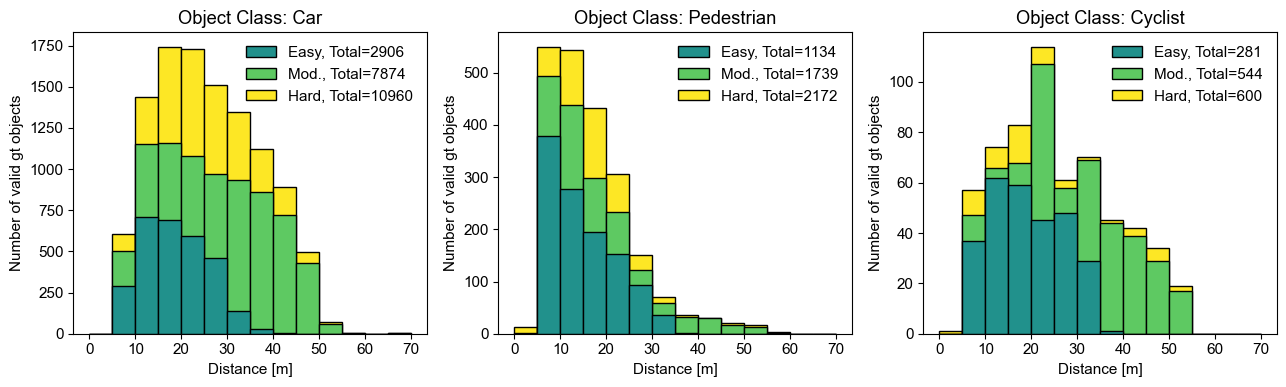

In [7]:
# Compact visualization
class_list=['Car','Pedestrian','Cyclist']
difficulty_list=['Easy','Mod.','Hard']
valid_gt_count = {'Car':[0, 0, 0], 'Pedestrian':[0, 0, 0],'Cyclist':[0, 0, 0]}
for obj_class, obj_class_name in enumerate(class_list):
    for difficulty in range(0, 3):
        _, valid_gt_origins, dist, _, _, _ = find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set)
        valid_gt_count[obj_class_name][difficulty] = len(valid_gt_origins)
        print(max(dist))
print(valid_gt_count)
# obj_class = 0 # 0=car, 1=ped, 2=cyc
# difficulty = 0 # 0=easy, 1=moderate, 2=hard
# IoU_type = 0 # 0=[0.7, 0,7, 0,7], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
#              # 1=[0.7, 0.5, 0,5], [0.5, 0.25, 0.25], [0.5, 0.25, 0.25]
viridis = plt.cm.get_cmap('viridis', 5)
N_bins=14
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=False)
fig.set_size_inches(13,4)
for obj_class, obj_class_name in enumerate(class_list):
    for difficulty in range(2, -1, -1):
        _, _, dist, _, _, _ = find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set)
        N, bins, cur_patches = axs[obj_class].hist(dist, N_bins, range=[0, 70], 
                                                   color=viridis.colors[2+difficulty], edgecolor='black')
    axs[obj_class].set_ylabel('Number of valid gt objects')
    axs[obj_class].set_xlabel('Distance [m]');
    axs[obj_class].set_xticks(np.arange(0, 80, step=10))
    axs[obj_class].set_title('Object Class: '+obj_class_name)
    handles = [Rectangle((0,0),1,1,color=viridis.colors[2+difficulty],ec="k") for difficulty in [0, 1, 2]]
    labels= ["Easy, Total="+str(valid_gt_count[obj_class_name][0]),
             "Mod., Total="+str(valid_gt_count[obj_class_name][1]), 
             "Hard, Total="+str(valid_gt_count[obj_class_name][2])]
    axs[obj_class].legend(handles, labels,frameon=False)
# plt.suptitle('Distribution of object distance to LiDAR laser scanner')
# plt.savefig(figure_dir +'dist_hist_compact.pdf',format='pdf',bbox_inches='tight')

/tmp/ipykernel_143954/1400712181.py:45: RuntimeWarning: invalid value encountered in long_scalars
  recall = 1 - non_detected_count/N_per_bin[distance_bin_ind]


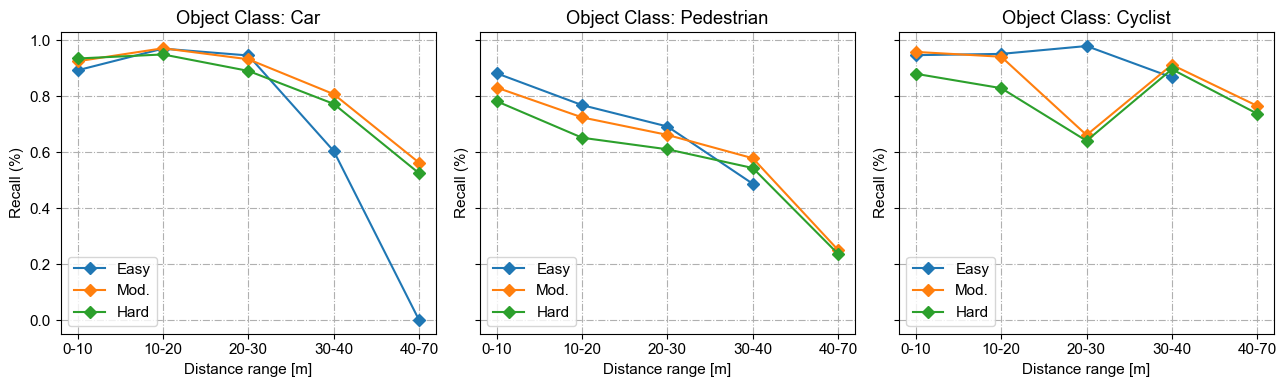

In [8]:
edges = np.array([[0, 10], [10, 20], [20, 30], [30, 40],
                  [40, 70]])
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
bins = np.array([0, 10, 20, 30, 40, 70])
# Load non-detected list
# obj_class = 0 # 0=car, 1=ped, 2=cyc
recall_dict = {'Car':np.zeros((3,len(bins)-1)), 'Pedestrian':np.zeros((3,len(bins)-1)), 'Cyclist':np.zeros((3,len(bins)-1))}
for obj_class, obj_class_name in enumerate(class_list):
    # print(obj_class_name)
    for difficulty, difficulty_name in enumerate(difficulty_list):
        # print(difficulty_name)
        # difficulty = 2 # 0=easy, 1=moderate, 2=hard
        IoU_type = 0 # 0=[0.7, 0,7, 0,7], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
                    # 1=[0.7, 0.5, 0,5], [0.5, 0.25, 0.25], [0.5, 0.25, 0.25]
        # Load ignored_gt list
        ignored_gts_file = '/home/user/PCcompression/Results/pcdet_object_analysis_second/raw/ignored_gts_class'+str(obj_class)+'_diff'+str(difficulty)+'_type'+str(IoU_type)+'.npy' 
        ignored_gts_list = np.load(ignored_gts_file,allow_pickle=True)
        # Load non-detected gt list
        non_detected_file = '/home/user/PCcompression/Results/pcdet_object_analysis_second/raw/non_detected_list_class'+str(obj_class)+'_diff'+str(difficulty)+'_type'+str(IoU_type)+'.npy' 
        non_detected_list = np.load(non_detected_file,allow_pickle=True)
        # Collect frames with non-detected objects
        # Create a dictionary
        non_detected_dict = {}
        non_detected_dict['frames']=[]
        non_detected_dict['gt_inds']=[]
        for i in range(len(non_detected_list)):
            if not len(non_detected_list[i]) == 0:
                non_detected_dict['frames'].append(i)
                non_detected_dict['gt_inds'].append(non_detected_list[i])
        # Create valid gts list
        valid_gts_list = [np.where(ignored_gts_list[val_frame_order]==0)[0] for val_frame_order in range(len(val_inds))]
        # print(valid_gts_list[0:10])
        _, valid_gt_origins, dist, _, _, dist_per_frame = find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set)
        num_valid_gts = len(valid_gt_origins)
        N_per_bin, _ = np.histogram(dist, bins)
        for distance_bin_ind in range(0,len(edges)):
            non_detected_count = 0
            for val_frame_order, (valid_gts, non_detected, dist) in enumerate(zip(valid_gts_list, non_detected_list, dist_per_frame)):
                if not len(non_detected)==0:
                    for obj_ind in non_detected:
                        non_detected_obj_ind = np.where(valid_gts==obj_ind)[0][0]
                        if dist[non_detected_obj_ind]>=edges[distance_bin_ind][0] and dist[non_detected_obj_ind]<edges[distance_bin_ind][1]:
                            non_detected_count = non_detected_count + 1
            # print(non_detected_count)
            recall = 1 - non_detected_count/N_per_bin[distance_bin_ind]
            # print(recall)
            recall_dict[obj_class_name][difficulty, distance_bin_ind] = recall

# Plot the recall for each object class
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
for obj_class, obj_class_name in enumerate(class_list):
    for difficulty, difficulty_name in enumerate(difficulty_list):
        _, _, dist, _, _, _ = find_valid_origins(obj_class, difficulty, velo_pos_val_set, velo_origin_val_set)
        N_per_bin, _ = np.histogram(dist, bins)
        axs[obj_class].plot(recall_dict[obj_class_name][difficulty,:],'D-', label=difficulty_name)# Missing x
        axs[obj_class].set_ylabel('Recall (%)')
        axs[obj_class].set_xlabel('Distance range [m]');
        axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
        axs[obj_class].set_title('Object Class: '+obj_class_name)
        axs[obj_class].legend(loc='lower left')
        axs[obj_class].grid(True, linestyle='-.')
        # for distance_bin_ind in range(0,len(edges)):
        #     axs[obj_class].annotate(str(N_per_bin[distance_bin_ind]),(distance_bin_ind,1))

# plt.savefig(figure_dir +'recall_vs_distance.pdf',format='pdf',bbox_inches='tight')
# Next: Use a 3d bar chart to show exact numbers of gt and recalled.

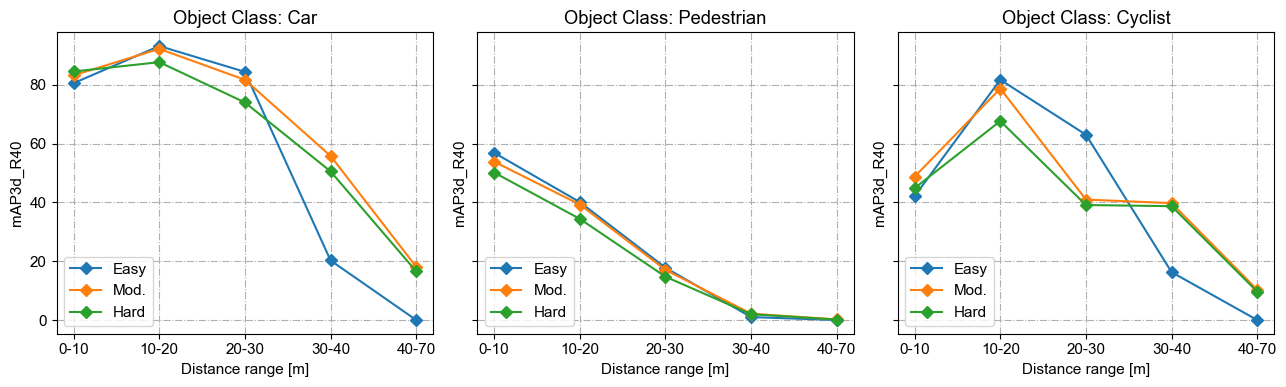

In [9]:
range_type_list=[0, 1, 2, 3, 4]
result_dir_root='/home/user/PCcompression/Results/AP_files_second/raw'
metric = 'mAP3d_R40'
IoU_criteria=0 
# Plot the recall for each object class
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
for obj_class, obj_class_name in enumerate(class_list):
    AP_all_ranges = []
    for range_type in range_type_list:
        result_dir = result_dir_root + '/range_'+str(range_type)+'/'
        metrics = eval_util.load_AP_single_setting(result_dir)
        AP_all_ranges.append(metrics)
    for difficulty, difficulty_name in enumerate(difficulty_list):
        AP_array = [AP_all_ranges[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
        axs[obj_class].plot(AP_array,'D-', label=difficulty_name)# Missing x
        axs[obj_class].set_ylabel(metric)
        axs[obj_class].set_xlabel('Distance range [m]');
        axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
        axs[obj_class].set_title('Object Class: '+obj_class_name)
        axs[obj_class].legend(loc='lower left')
        axs[obj_class].grid(True, linestyle='-.')
        # for distance_bin_ind in range(0,len(edges)):
        #     axs[obj_class].annotate(str(N_per_bin[distance_bin_ind]),(distance_bin_ind,1))

# plt.savefig(figure_dir +'AP_vs_distance_raw.pdf',format='pdf',bbox_inches='tight')
AP_all_ranges_raw = AP_all_ranges

In [10]:
figure_dir

'/home/user/PCcompression/Results/figures/AP_vs_distance/'

In [11]:
# BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
# SUB_CFG_dict = {'octree-raht':['octree_raht_lossless_lossy', 'octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup'],
#                'octree-predlift':['lossless-geom-lossless-attrs', 'lossless-geom-nearlossless-attrs', 'lossless-geom-lossy-attrs', 'lossy-geom-lossy-attrs'],
#                'predgeom-raht':['lossless-geom-lossy-attrs', 'lossy-geom-lossy-attrs'],
#                'predgeom-predlift':['lossless-geom-lossless-attrs', 'lossless-geom-nearlossless-attrs', 'lossless-geom-lossy-attrs', 'lossy-geom-lossy-attrs']}
# rate_list_dict = {'octree-raht':[[1, 2, 3, 4, 5, 6], [3, 4, 5, 6], [2, 3, 4, 5, 6]],
#                'octree-predlift':[[1], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [3, 4, 5, 6]],
#                'predgeom-raht':[[1, 2, 3, 4, 5, 6], [4, 5, 6]],
#                'predgeom-predlift':[[1], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [4, 5, 6]]}

# BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
# SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup'],
#                'octree-predlift':['lossy-geom-lossy-attrs'],
#                'predgeom-raht':['lossy-geom-lossy-attrs'],
#                'predgeom-predlift':['lossy-geom-lossy-attrs']}
# rate_list_dict = {'octree-raht':[[3, 4, 5, 6], [2, 3, 4, 5, 6]],
#                'octree-predlift':[[3, 4, 5, 6]],
#                'predgeom-raht':[[4, 5, 6]],
#                'predgeom-predlift':[[4, 5, 6]]}
BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup'],
               'octree-predlift':['lossy-geom-lossy-attrs'],
               'predgeom-raht':['lossy-geom-lossy-attrs'],
               'predgeom-predlift':['lossy-geom-lossy-attrs']}
rate_list_dict = {'octree-raht':[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]],
               'octree-predlift':[[1, 2, 3, 4, 5, 6]],
               'predgeom-raht':[[1, 2, 3, 4, 5, 6]],
               'predgeom-predlift':[[1, 2, 3, 4, 5, 6]]}

[2.30015985 2.74348236 3.15111562 3.52763056 3.88311341 4.21901803]


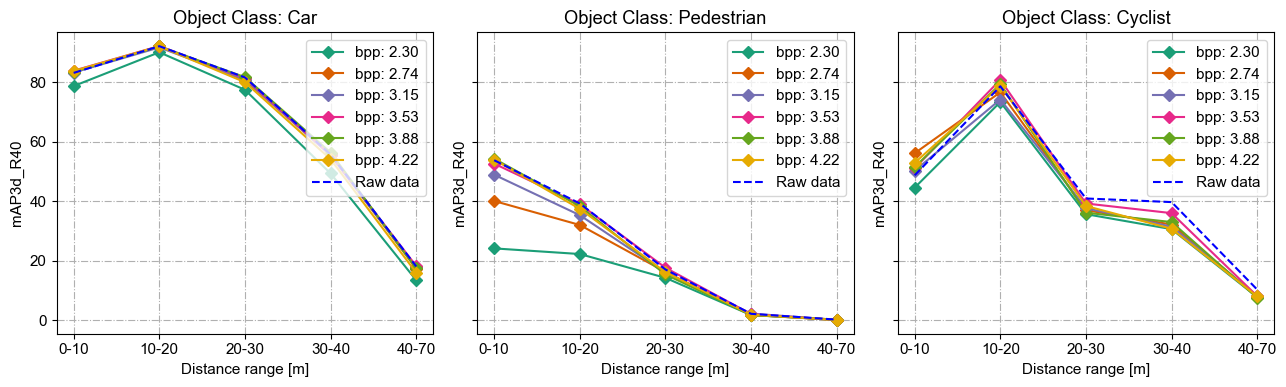

In [12]:
consistent_colormap = plt.cm.get_cmap('Dark2')
range_type_list=[0, 1, 2, 3, 4]
CFG_pair = {'BASE':0, 'SUB':0}
BASE_CFG = BASE_CFG_list[CFG_pair['BASE']]
SUB_CFG = SUB_CFG_dict[BASE_CFG][CFG_pair['SUB']]
AP_data_dir_root='/home/user/PCcompression/Results/AP_files_second/'
result_dir_root='/home/user/PCcompression/Results/AP_files_second/'+BASE_CFG+'/'+SUB_CFG+'/'
rets = eval_util.load_one_CFG(rate_list_dict, BASE_CFG_list, SUB_CFG_dict, AP_data_dir_root, CFG_pair)
metrics_cfg, CFG_full_name, rate_dict, rate_list = rets
print(rate_dict['total_bpp'])
# rate_list = rate_list_dict[BASE_CFG][CFG_pair['SUB']]
metric = 'mAP3d_R40'
IoU_criteria=0 
# Plot the recall for each object class
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
difficulty = 1
for obj_class, obj_class_name in enumerate(class_list):
    AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
    for rate_ind, rate in enumerate(rate_list):
        AP_all_ranges = []
        for range_type in range_type_list:
            result_dir = result_dir_root +'r0'+str(rate)+'/range_'+str(range_type)+'/'
            metrics = eval_util.load_AP_single_setting(result_dir)
            AP_all_ranges.append(metrics)
        difficulty = 1
        difficulty_name = difficulty_list[difficulty]
        AP_array = [AP_all_ranges[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
        axs[obj_class].plot(AP_array,'D-', color=consistent_colormap.colors[rate-1], label='bpp: %.2f' % rate_dict['total_bpp'][rate_ind])# Missing x
        axs[obj_class].set_ylabel(metric)
        axs[obj_class].set_xlabel('Distance range [m]')
        axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
        axs[obj_class].set_title('Object Class: '+obj_class_name)
        # axs[obj_class].legend(loc='lower left')
        axs[obj_class].grid(True, linestyle='-.')
    axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
    axs[obj_class].legend(loc='upper right')
    
    

# plt.savefig(figure_dir +'Mar_3/AP_vs_distance_'+BASE_CFG+'_'+SUB_CFG+'.pdf',format='pdf',bbox_inches='tight')

In [13]:
CFG_pair = {'BASE':0, 'SUB':1}# 1=no duplicate, 2=keep duplicates
# rets = eval_util.load_one_CFG(rate_list_dict, BASE_CFG_list, SUB_CFG_dict, AP_data_dir_root, CFG_pair)
# metrics_cfg, CFG_full_name, rate_dict, rate_list = rets
# Plot position bpp and attr bpp as stacked bar plot
BASE_CFG_ind = CFG_pair['BASE']
SUB_CFG_ind = CFG_pair['SUB']
br_dict = eval_util.load_br_new(BASE_CFG_list, BASE_CFG_ind, SUB_CFG_dict, SUB_CFG_ind, [1,2,3,4,5,6], bitrate_root)
rate_list = rate_list_dict[BASE_CFG_list[BASE_CFG_ind]][SUB_CFG_ind]

bpp_bars = {'pos_bpp':br_dict['pos_bpp'],
        'attr_bpp':br_dict['attr_bpp']}
print(np.round(br_dict['pos_bpp'],2))
print(np.round(br_dict['attr_bpp'],3))
print(np.round(br_dict['total_bpp'],3))

[2.93 3.34 3.71 4.03 4.34 4.62]
[0.331 0.331 0.333 0.333 0.333 0.334]
[3.263 3.673 4.04  4.367 4.671 4.958]


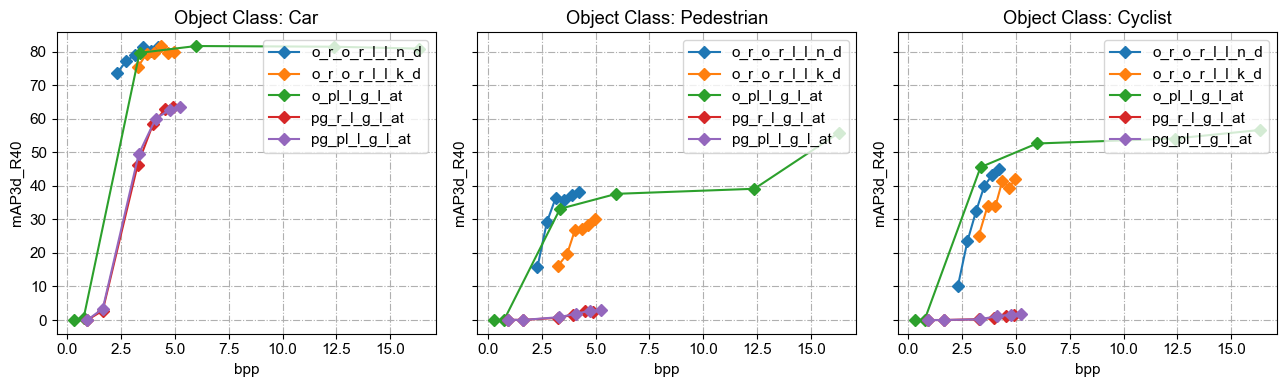

In [14]:
# AP vs bpp plot for all the distance ranges: Unfinished, comparison between a pair of cfgs
range_type = 0
metric = 'mAP3d_R40'
IoU_criteria=0 
# Plot the mAP for each object class
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
difficulty = 1
# CFG_pairs = [{'BASE':0, 'SUB':1}, 
#              {'BASE':0, 'SUB':2}]
CFG_pairs = [{'BASE':0, 'SUB':0}, 
             {'BASE':0, 'SUB':1},
             {'BASE':1, 'SUB':0},
             {'BASE':2, 'SUB':0},
             {'BASE':3, 'SUB':0},]
for obj_class, obj_class_name in enumerate(class_list):
    # AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
    for CFG_pair in CFG_pairs:
        BASE_CFG = BASE_CFG_list[CFG_pair['BASE']]
        SUB_CFG = SUB_CFG_dict[BASE_CFG][CFG_pair['SUB']]
        AP_data_dir_root='/home/user/PCcompression/Results/AP_files/'
        result_dir_root=AP_data_dir_root+BASE_CFG+'/'+SUB_CFG+'/'
        rets = eval_util.load_one_CFG(rate_list_dict, BASE_CFG_list, SUB_CFG_dict, AP_data_dir_root, CFG_pair)
        _, _, rate_dict, rate_list = rets
        AP_all_rates = []
        for rate in rate_list:
            result_dir = result_dir_root +'r0'+str(rate)+'/range_'+str(range_type)+'/'
            metrics = eval_util.load_AP_single_setting(result_dir)
            AP_all_rates.append(metrics)
        AP_array = [AP_all_rates[rate_ind][metric][obj_class, difficulty, IoU_criteria] for rate_ind, _ in enumerate(rate_list)]
        difficulty_name = difficulty_list[difficulty]
        axs[obj_class].plot(rate_dict['total_bpp'], AP_array,'D-',label=eval_util.short_abbr(BASE_CFG, SUB_CFG))# Missing x
        axs[obj_class].set_ylabel(metric)
        axs[obj_class].set_xlabel('bpp')
        axs[obj_class].set_title('Object Class: '+obj_class_name)
        axs[obj_class].grid(True, linestyle='-.')
        # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
        axs[obj_class].legend(loc='upper right')

# plt.savefig(figure_dir +'/AP_vs_bpp_per_distance_range_'+str(range_type)+'.pdf',format='pdf',bbox_inches='tight')

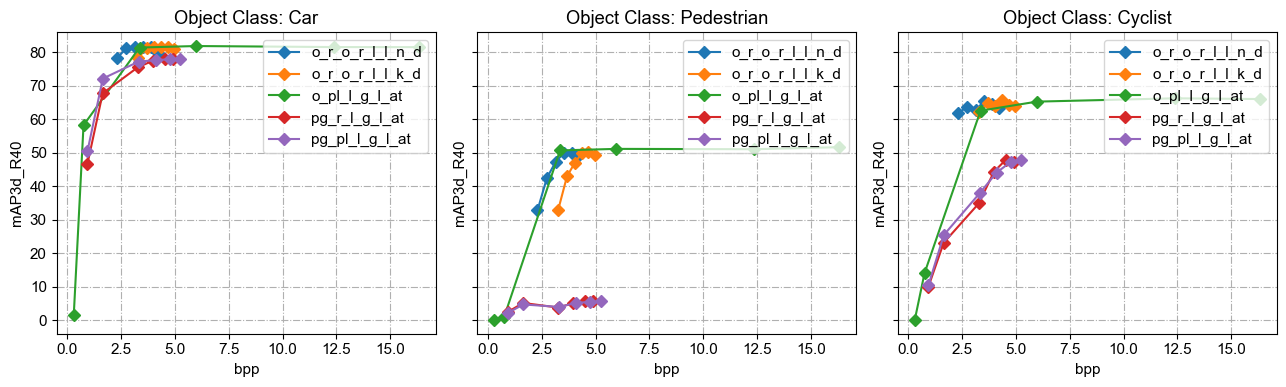

In [15]:
# AP vs bpp plot for all the distance ranges: Unfinished, comparison between a pair of cfgs
metric = 'mAP3d_R40'
IoU_criteria=0 
# Plot the mAP for each object class
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
difficulty = 1
# CFG_pairs = [{'BASE':0, 'SUB':1}, 
#              {'BASE':0, 'SUB':2}]
CFG_pairs = [{'BASE':0, 'SUB':0}, 
             {'BASE':0, 'SUB':1},
             {'BASE':1, 'SUB':0},
             {'BASE':2, 'SUB':0},
             {'BASE':3, 'SUB':0},]
for obj_class, obj_class_name in enumerate(class_list):
    # AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
    for CFG_pair in CFG_pairs:
        BASE_CFG = BASE_CFG_list[CFG_pair['BASE']]
        SUB_CFG = SUB_CFG_dict[BASE_CFG][CFG_pair['SUB']]
        AP_data_dir_root='/home/user/PCcompression/Results/AP_files_second/'
        result_dir_root=AP_data_dir_root+BASE_CFG+'/'+SUB_CFG+'/'
        rets = eval_util.load_one_CFG(rate_list_dict, BASE_CFG_list, SUB_CFG_dict, AP_data_dir_root, CFG_pair)
        metrics_cfg, CFG_full_name, rate_dict, rate_list = rets
        AP_all_rates = []
        for rate in rate_list:
            result_dir = result_dir_root +'r0'+str(rate)+'/'
            metrics = eval_util.load_AP_single_setting(result_dir)
            AP_all_rates.append(metrics)
        AP_array = [AP_all_rates[rate_ind][metric][obj_class, difficulty, IoU_criteria] for rate_ind, _ in enumerate(rate_list)]
        difficulty_name = difficulty_list[difficulty]
        axs[obj_class].plot(rate_dict['total_bpp'], AP_array,'D-',label=(eval_util.short_abbr(BASE_CFG, SUB_CFG)))# Missing x
        axs[obj_class].set_ylabel(metric)
        axs[obj_class].set_xlabel('bpp')
        axs[obj_class].set_title('Object Class: '+obj_class_name)
        axs[obj_class].grid(True, linestyle='-.')
        # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
        axs[obj_class].legend(loc='upper right')

# plt.savefig(figure_dir +'/AP_vs_bpp_per_distance_range_'+str(range_type)+'.pdf',format='pdf',bbox_inches='tight')

In [16]:
# BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
# SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup'],
#                'octree-predlift':['lossy-geom-lossy-attrs'],
#                'predgeom-raht':['lossy-geom-lossy-attrs'],
#                'predgeom-predlift':['lossy-geom-lossy-attrs']}
# rate_list_dict = {'octree-raht':[[3, 4, 5, 6], [2, 3, 4, 5, 6]],
#                'octree-predlift':[[3, 4, 5, 6]],
#                'predgeom-raht':[[4, 5, 6]],
#                'predgeom-predlift':[[4, 5, 6]]}

BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup', 
                               'octree_raht_lossy_lossy_no_dup_distance'],
               'octree-predlift':['lossy-geom-lossy-attrs'],
               'predgeom-raht':['lossy-geom-lossy-attrs'],
               'predgeom-predlift':['lossy-geom-lossy-attrs']}
rate_list_dict = {'octree-raht':[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3]],
               'octree-predlift':[[1, 2, 3, 4, 5, 6]],
               'predgeom-raht':[[1, 2, 3, 4, 5, 6]],
               'predgeom-predlift':[[1, 2, 3, 4, 5, 6]]}

class_list=['Car','Pedestrian','Cyclist']
difficulty_list=['Easy','Mod.','Hard']

bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'
br = eval_util.load_br_new(BASE_CFG_list, 3, SUB_CFG_dict, 0, [3, 4, 5, 6], bitrate_root)
print(br['total_bpp'])

[3.30893003 4.09676304 4.74855422 5.24385472]


## AP versus bpp for all CFG types under different range type (with range as the X-axis)

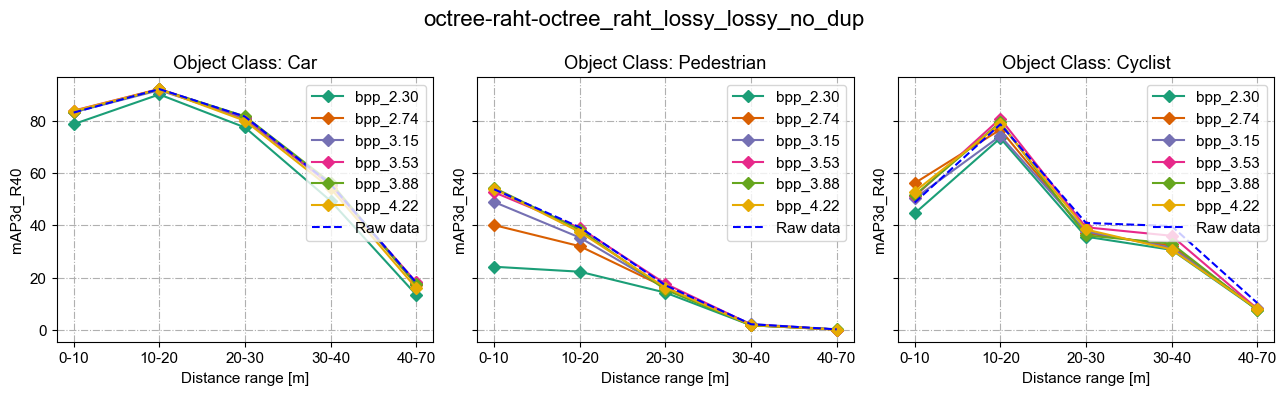

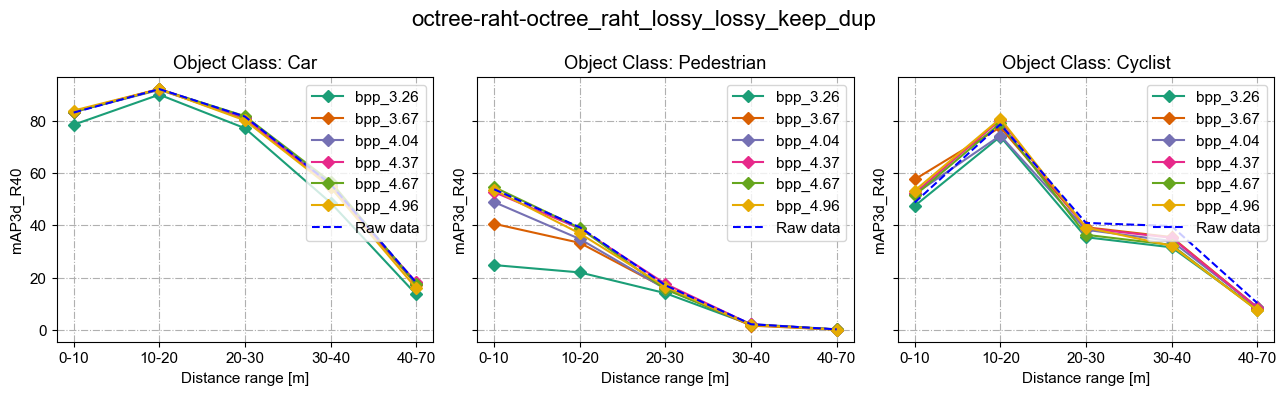

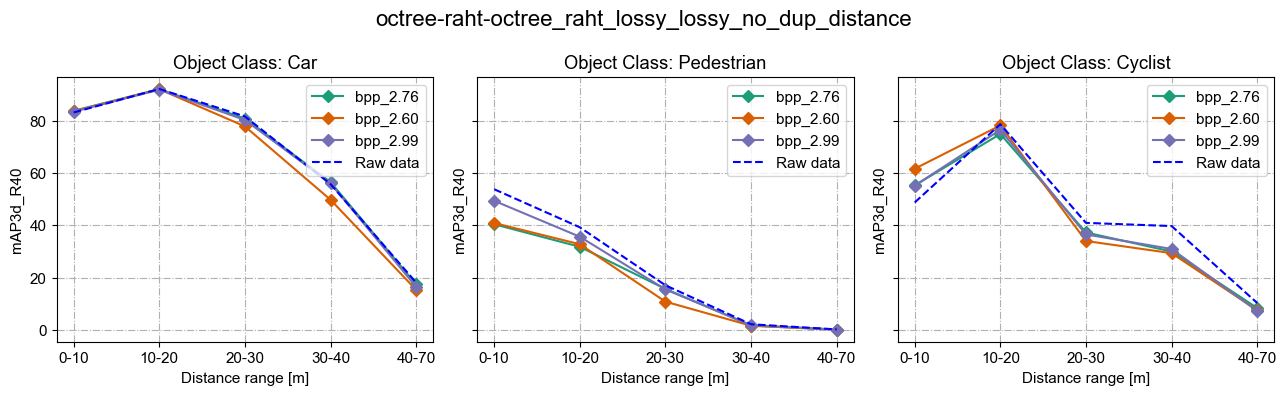

In [17]:
consistent_colormap = plt.cm.get_cmap('Dark2')

BASE_CFG_list = ['octree-raht']
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
metric = 'mAP3d_R40'
IoU_criteria = 0 
difficulty = 1
AP_data_dir_root = '/home/user/PCcompression/Results/AP_files_second/'
bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

range_types = [0, 1, 2, 3, 4]

for BASE_CFG in BASE_CFG_list:
    for rate_list_ind, SUB_CFG in enumerate(SUB_CFG_dict[BASE_CFG]):
        # Plot the mAP for each object class
        fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
        fig.set_size_inches(13,4)
        
        rate_list = rate_list_dict[BASE_CFG][rate_list_ind] # the rate list for the CFG

        result_dir_root = AP_data_dir_root + BASE_CFG + '/' + SUB_CFG + '/'
        bitrate_dir = bitrate_root + BASE_CFG + '/' + SUB_CFG + '/'

        rets = eval_util.load_one_CFG_dir(BASE_CFG, SUB_CFG, AP_data_dir_root, rate_list, bitrate_dir)
        metrics_cfg, CFG_full_name, rate_dict, rate_list = rets

        for obj_class, obj_class_name in enumerate(class_list):
            AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
            for rate_ind, rate in enumerate(rate_list):
                AP_all_rates = []
                for range_type  in range_types:
                    result_dir = result_dir_root +'r0'+str(rate) + '/range_' + str(range_type) + '/'
                    metrics = eval_util.load_AP_single_setting(result_dir)
                    AP_all_rates.append(metrics)

                
                AP = [AP_all_rates[i][metric][obj_class, difficulty, IoU_criteria] for i, _ in enumerate(range_types)]
                axs[obj_class].plot(range_types, AP,'D-', color=consistent_colormap.colors[rate-1], label='bpp_{:.2f}'.format(rate_dict['total_bpp'][rate_ind]))# Missing x

            axs[obj_class].set_ylabel(metric)
            axs[obj_class].set_xlabel('Distance range [m]')
            axs[obj_class].set_title('Object Class: '+obj_class_name)
            axs[obj_class].grid(True, linestyle='-.')
            axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
                # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
            axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
            axs[obj_class].legend(loc='upper right')

        fig.suptitle(BASE_CFG + '-' + SUB_CFG, fontsize=16)


        

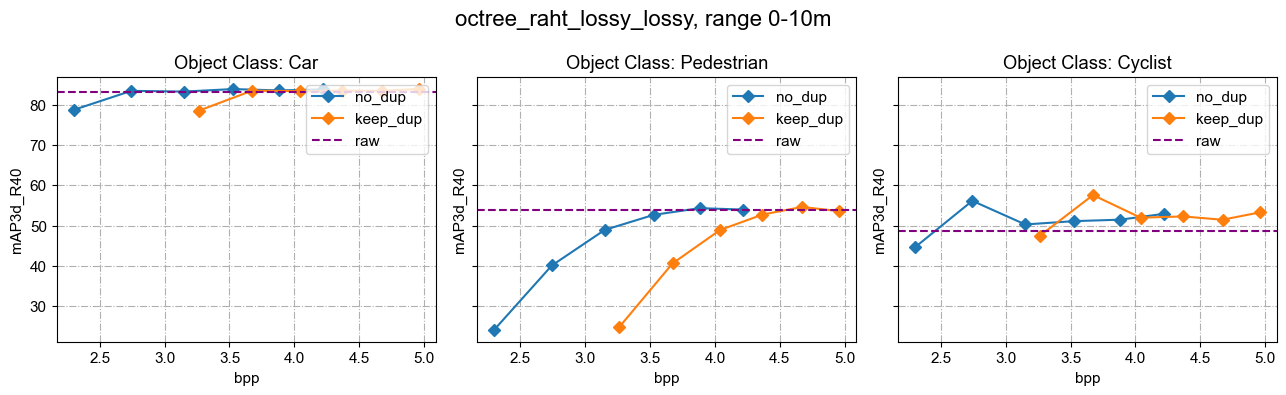

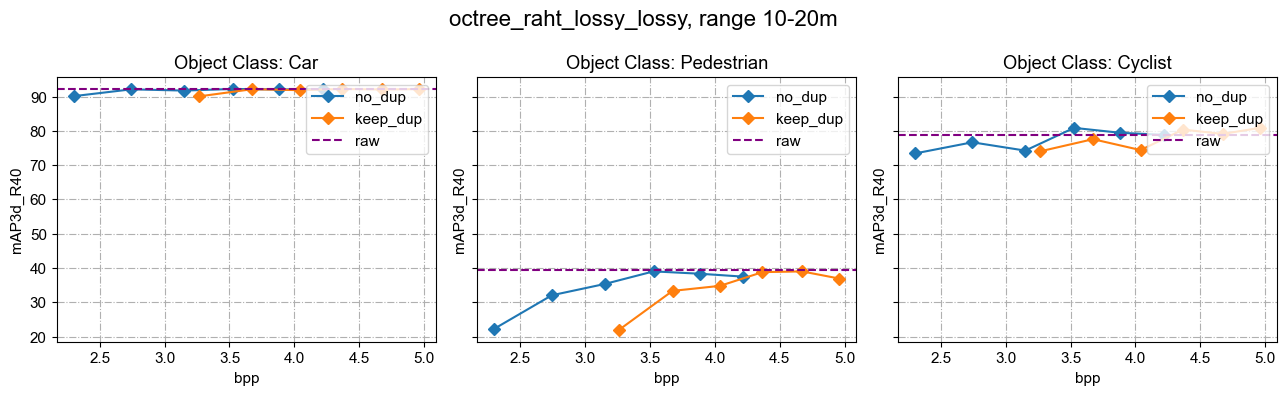

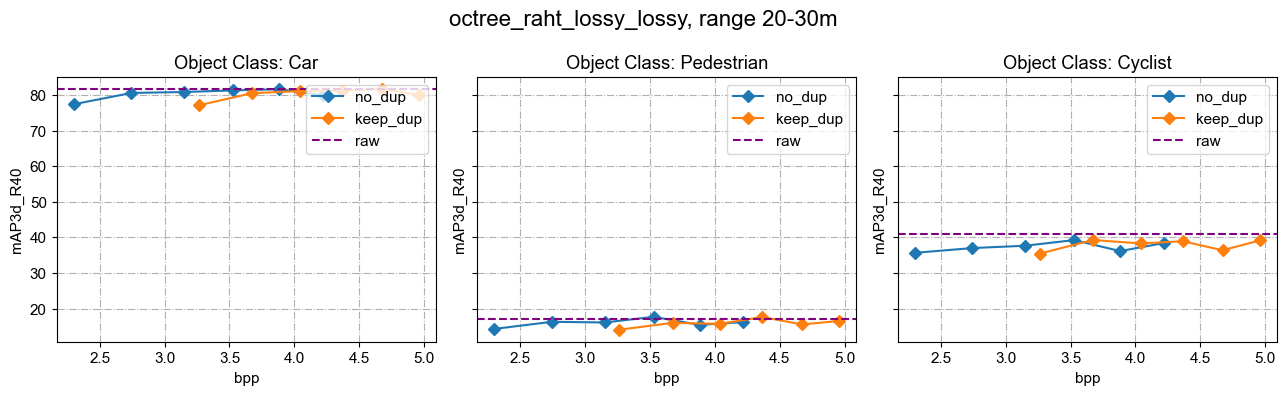

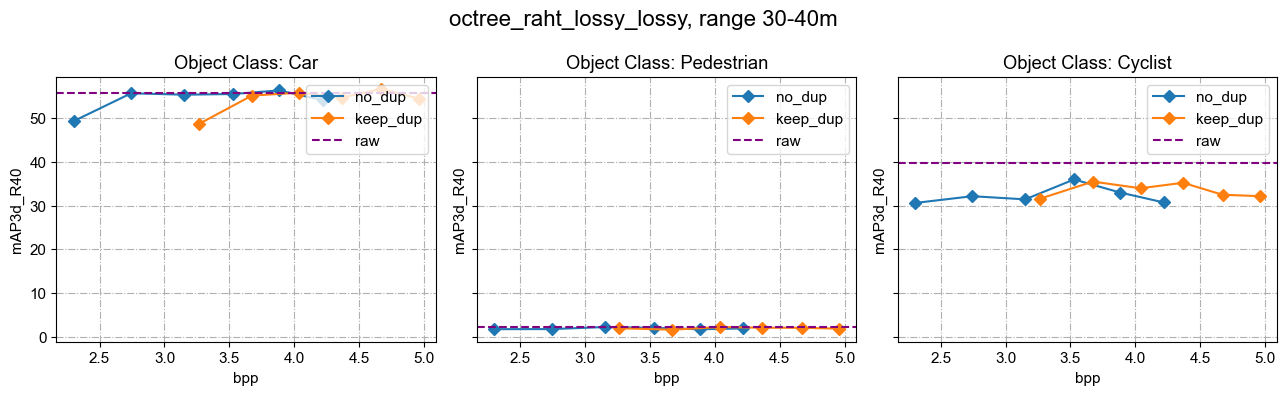

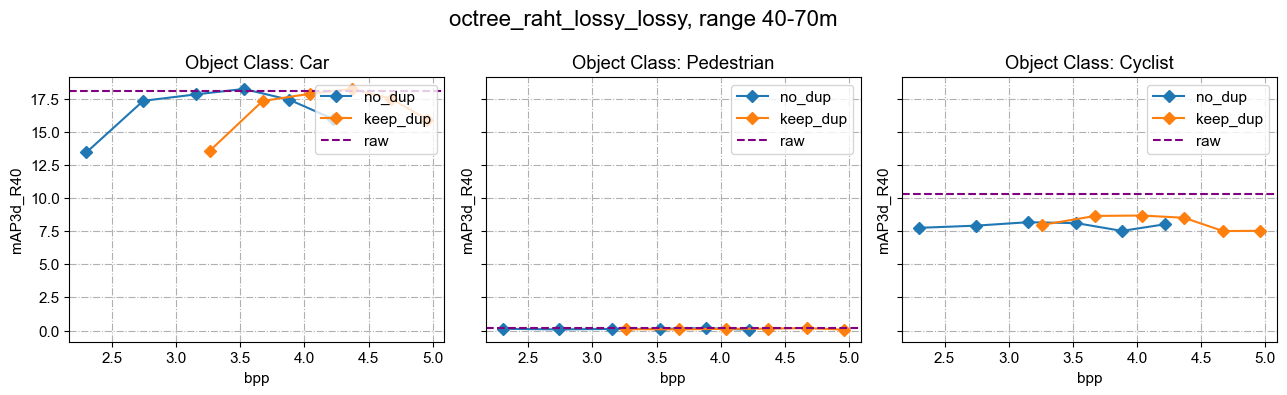

In [18]:
BASE_CFG_list = ['octree-raht']
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
metric = 'mAP3d_R40'
IoU_criteria = 0 
difficulty = 1
AP_data_dir_root = '/home/user/PCcompression/Results/AP_files_second/'
bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

range_types = [0, 1, 2, 3, 4]
for range_type in range_types:
    # Plot the mAP for each object class
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
    fig.set_size_inches(13,4)

    for BASE_CFG in BASE_CFG_list:
        for rate_list_ind, SUB_CFG in enumerate(SUB_CFG_dict[BASE_CFG][:2]):
            
            rate_list = rate_list_dict[BASE_CFG][rate_list_ind] # the rate list for the CFG

            result_dir_root = AP_data_dir_root + BASE_CFG + '/' + SUB_CFG + '/'
            bitrate_dir = bitrate_root + BASE_CFG + '/' + SUB_CFG + '/'

            rets = eval_util.load_one_CFG_dir(BASE_CFG, SUB_CFG, AP_data_dir_root, rate_list, bitrate_dir)
            metrics_cfg, CFG_full_name, rate_dict, rate_list = rets

            for obj_class, obj_class_name in enumerate(class_list):
                AP_all_rates = []
                for rate_ind, rate in enumerate(rate_list):
                    

                    result_dir = result_dir_root +'r0'+str(rate) + '/range_' + str(range_type) + '/'
                    metrics = eval_util.load_AP_single_setting(result_dir)
                    AP_all_rates.append(metrics)

                AP = [AP_all_rates[i][metric][obj_class, difficulty, IoU_criteria] for i, _ in enumerate(rate_list)]
                axs[obj_class].plot(rate_dict['total_bpp'], AP,'D-', label=SUB_CFG[24:])# Missing x

                axs[obj_class].set_ylabel(metric)
                axs[obj_class].set_xlabel('bpp')
                axs[obj_class].set_title('Object Class: '+obj_class_name)
                axs[obj_class].grid(True, linestyle='-.')
                # axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
                
    for obj_class, obj_class_name in enumerate(class_list):
        standard = AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria]
        axs[obj_class].axhline(y=standard, xmin=0, xmax=rate_dict['total_bpp'][-1], label='raw', ls='--', c='purple')
        axs[obj_class].legend(loc='upper right')
                

    fig.suptitle(SUB_CFG[:23] + ', range {}m'.format(edges_txt[range_type]), fontsize=16)